# 10/15/24: recognition phase plots
* As a reminder, 16 subjs across 29 session undergo 40-trial recognition phases, with 20 familiar & 20 novel images.  
* Subjs rate images from 1 (familiar, sure) to 6 (novel, sure).  

After wrangling all their data into 1 df, I plotted:  
1. Distribution of RTs  .
2. Rasters & PSTHs for example cells from each region. For the latter, I trimmed all trials to 5s.  
3. Distribution of avg FRs across trials (non-zero FRs only).  
4. Trial-avged FR for correct vs incorrect (note that these are imbalanced classes as printed above the plot).  
5. Trial-avged FR for (correct+high confidence) vs others (much better balanced).  


In [16]:
import warnings
warnings.filterwarnings("ignore")

import os, pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy.stats as stats, glob
from pynwb import NWBHDF5IO
from pathlib import Path
from convnwb.io import load_nwbfile

## check data

In [18]:
df = pd.read_pickle('neuron_by_trial_df.pkl')

# ensure no missing data
# note that there is 1 session with 48 neurons that has only 34 trials
# total neurons = 1409+48 = 1457
print(len(df) == (1409*41 + 48*35))

df_recognition = df[df['stim_phase'] == 'recognition']
print(f'len_df = {len(df)}, len_recog = {len(df_recognition)}')
# ensure correct number of rows were dropped
print(len(df)-1457 == len(df_recognition))

num_subjs = len(np.unique(df_recognition['subj']))
num_sessions = len(np.unique(df_recognition['sess']))
num_neurons = len(np.unique(df_recognition['neuron']))
print(f'{num_subjs} subjects, {num_sessions} sessions, {num_neurons} neurons')

# df_recognition = df_recognition[df_recognition['FR'] != 0]
df_recognition.head()

True
len_df = 59449, len_recog = 57992
True
16 subjects, 29 sessions, 1457 neurons


,subj,sess,neuron,region,start_time,stop_time,RT,trial_spikes,trial_aligned_spikes,num_spikes,FR,trial_smooth_spikes,trial_smooth_FR,stim_phase,stimulus_file,response_correct,response_confidence,actual_response
1,P41,P41CS_R1,P41CS_R1_21_1_679_4,amygdala,566.346460,577.078362,10.731902,"[566.79785075, 568.845881, 569.40153725, 576.0...","[0.4513907499999732, 2.499420999999984, 3.0550...",4,0.372721,"[1, 0, 0, 1, 1, 1, 1, 0, 0]",0.555556,recognition,old015.png,1.0,2.0,5.0
2,P41,P41CS_R1,P41CS_R1_21_1_679_4,amygdala,578.122799,582.712578,4.589779,[582.05028225],[3.927483250000023],1,0.217875,"[0, 0, 0, 0, 0, 0, 1, 1, 0]",0.222222,recognition,new021.png,1.0,3.0,1.0
3,P41,P41CS_R1,P41CS_R1_21_1_679_4,amygdala,583.755203,591.685106,7.929903,[589.2551855],[5.499982499999987],1,0.126105,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000000,recognition,new030.png,0.0,3.0,6.0
4,P41,P41CS_R1,P41CS_R1_21_1_679_4,amygdala,592.728012,597.998541,5.270529,"[593.583746, 593.7849335]","[0.855733999999984, 1.0569214999999303]",2,0.379469,"[1, 2, 1, 0, 0, 0, 0, 0, 0]",0.444444,recognition,old012.png,0.0,3.0,1.0
5,P41,P41CS_R1,P41CS_R1_21_1_679_4,amygdala,599.050103,603.022414,3.972311,"[599.334119, 600.3696805, 600.79902425, 602.03...","[0.2840159999999514, 1.319577499999923, 1.7489...",4,1.006971,"[1, 1, 2, 1, 1, 1, 0, 0, 0]",0.777778,recognition,old021.png,1.0,3.0,6.0


## RT distribution & outlier sessions

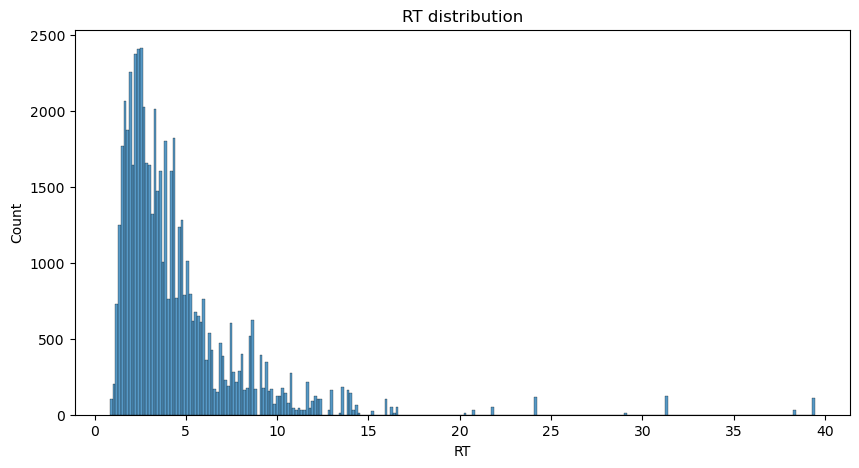

In [44]:
plt.figure(figsize=(10,5))
sns.histplot(df_recognition['RT'])
plt.title('RT distribution')
plt.show()

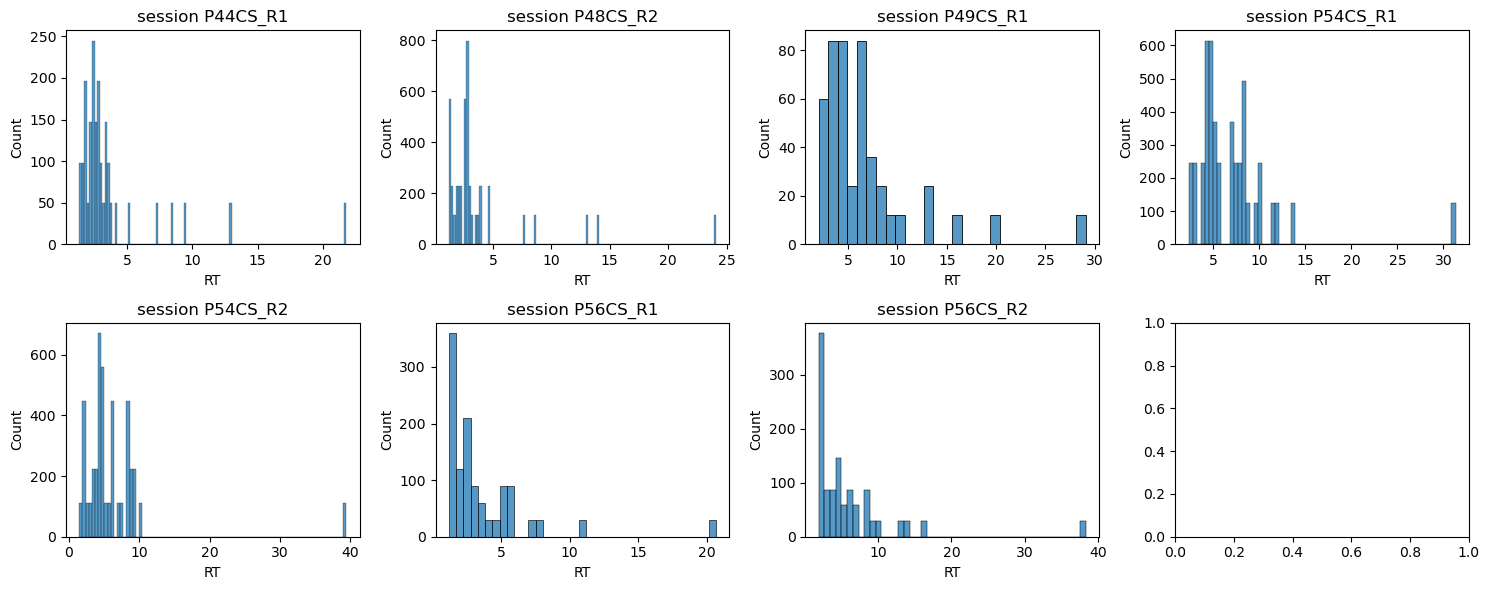

In [81]:
high_RT_df = df_recognition[df_recognition['RT'] > 20]
high_RT_sess_df = high_RT_df.groupby('sess').first().reset_index()
high_RT_sess = ['P44CS_R1', 'P48CS_R2', 'P49CS_R1', 'P54CS_R1', 'P54CS_R2', 'P56CS_R1', 'P56CS_R2']

fig, axs = plt.subplots(2, 4, figsize=(15,6))
axs, ax_count = axs.flatten(), 0

for sess_id, sess_df in df_recognition.groupby('sess'):
    
    if sess_id in high_RT_sess:

        sns.histplot(sess_df['RT'], ax=axs[ax_count])
        axs[ax_count].set_title(f'session {sess_id}')
        ax_count+=1

plt.tight_layout()
plt.show()


### example cell raster & PSTH by region

In [50]:
for region, region_df in df_recognition.groupby('region'):

    region_df.reset_index(drop=True).to_csv('tst_region.csv')

    for neuron, neuron_df in region_df.groupby('neuron'):

        neuron_df.reset_index(drop=True).to_csv('tst_neuron.csv')

        break
    break


30


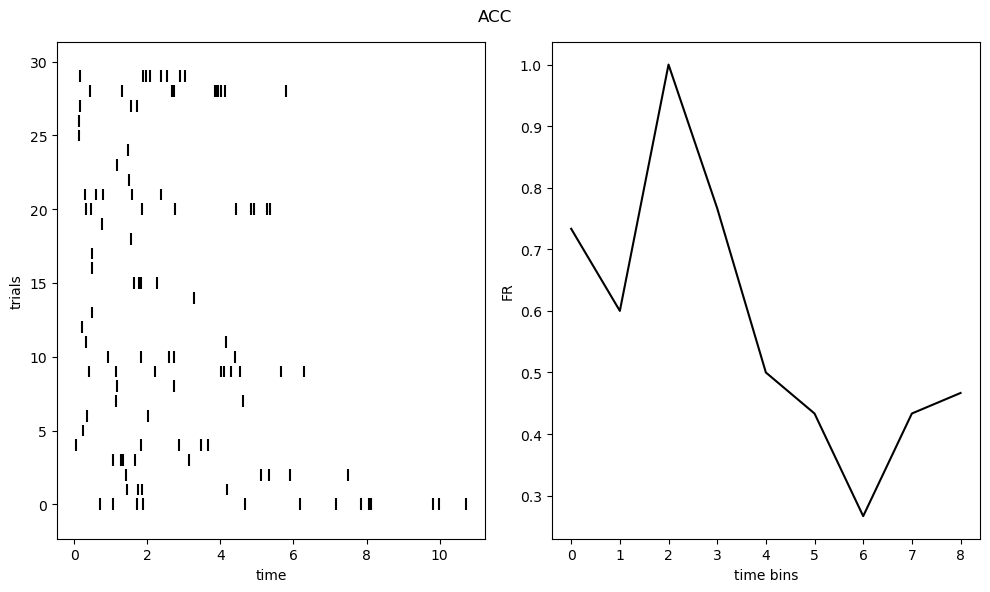

29


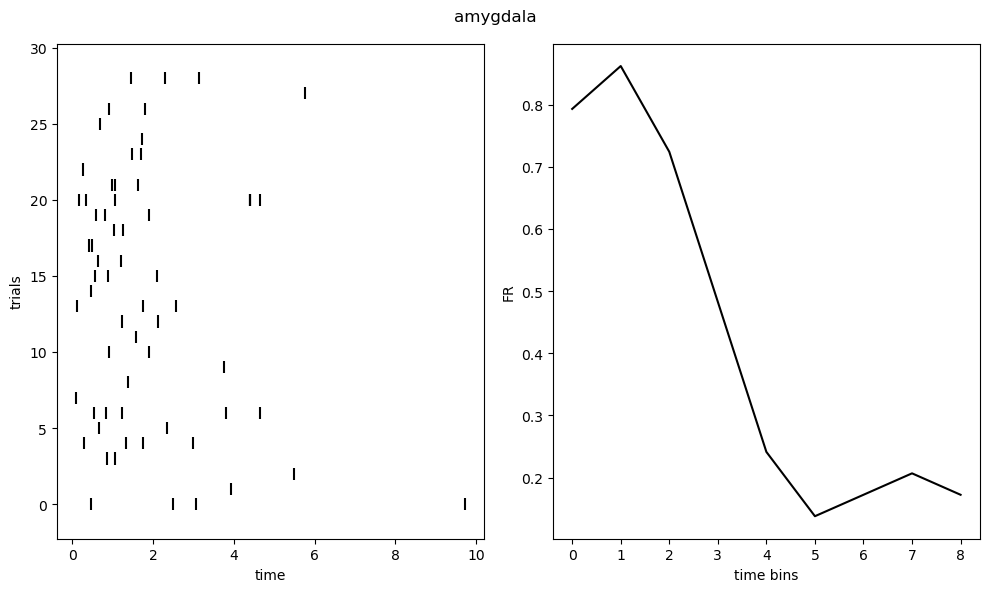

40


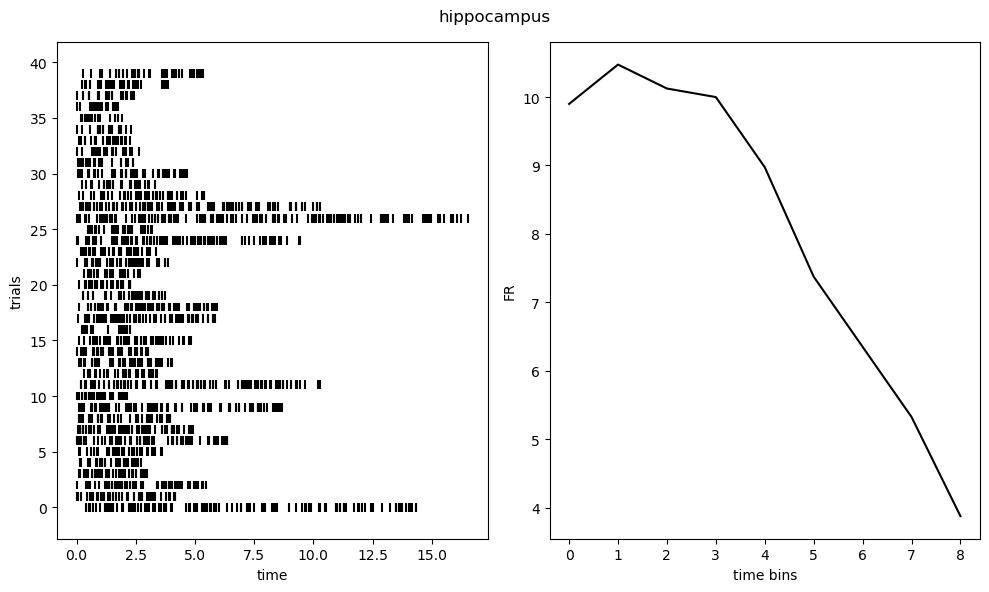

18


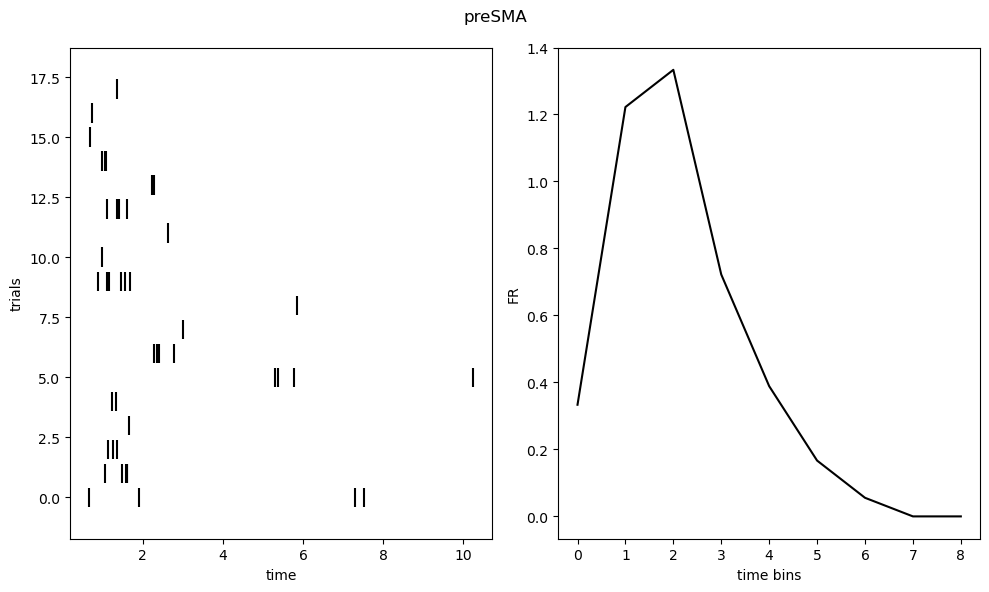

14


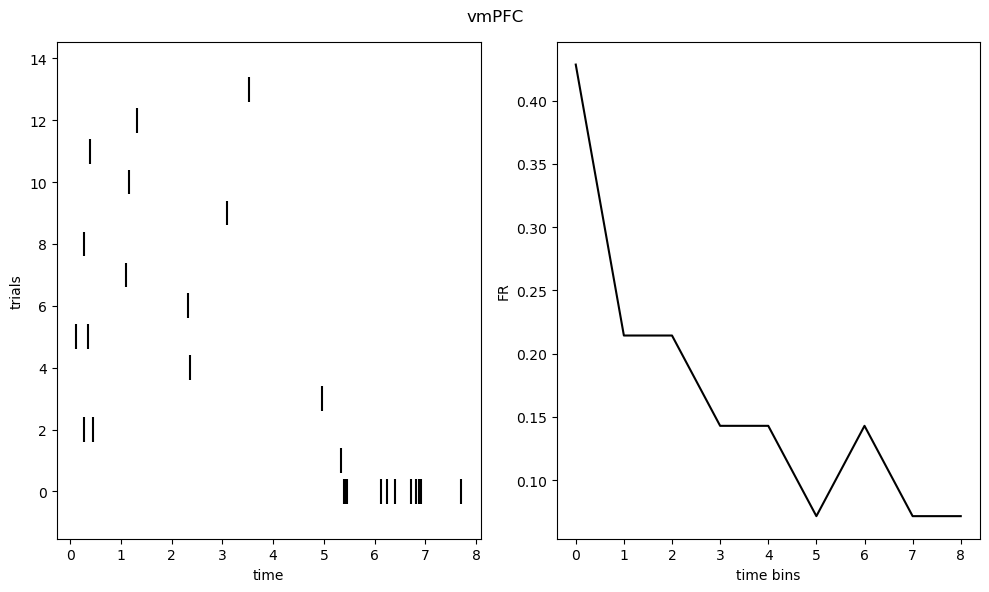

In [31]:
for region, region_df in df_recognition.groupby('region'):

    # print(region_df.head())
    # break
    neuron_num = 0

    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    fig.suptitle(region)

    for neuron, neuron_df in region_df.groupby('neuron'):

        neuron_num+=1
        if neuron_num == 1:
            
            print(len(neuron_df['trial_aligned_spikes']))
            ax[0].eventplot(neuron_df['trial_aligned_spikes'], linelengths=0.8, color='black')
            ax[0].set_ylabel('trials')
            ax[0].set_xlabel('time')
            ax[1].plot(np.mean(neuron_df['trial_smooth_spikes'], axis=0), color='black')
            ax[1].set_ylabel('FR')
            ax[1].set_xlabel('time bins')

            break

    plt.tight_layout()
    plt.show()  


### discard outliers with extreme FRs

48378


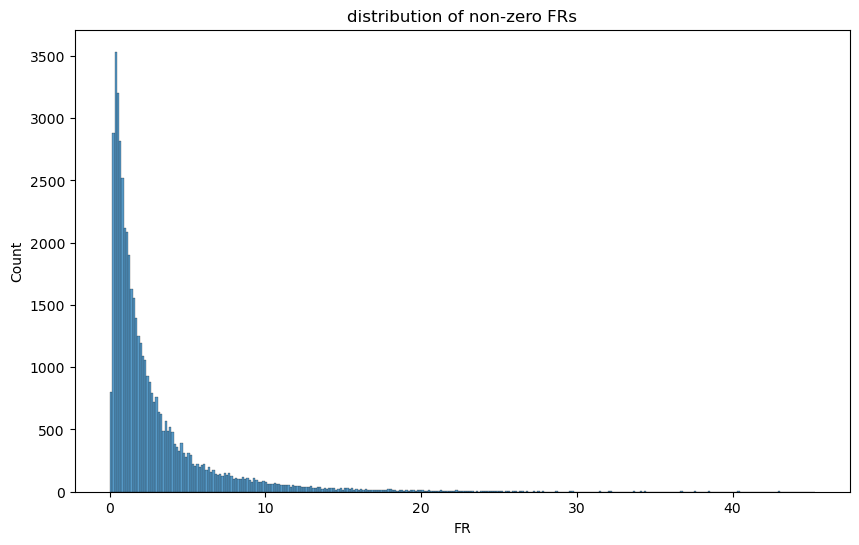

In [16]:
print(len(df_recognition))

# z_scores = stats.zscore(df_recognition['FR'])
# mask = (z_scores < 2) & (z_scores > -2)
# df_recognition = df_recognition[mask]

# print(f'num_trials after outlier removal: {len(df_recognition)}')

plt.figure(figsize=(10,6))
sns.histplot(df_recognition['FR'])
plt.title('distribution of non-zero FRs')
plt.show()

### trial-avged FRs by correctness

region       response_correct
ACC          0.0                  2460
             1.0                  5226
amygdala     0.0                  3461
             1.0                 12290
hippocampus  0.0                  2139
             1.0                  6640
preSMA       0.0                  2482
             1.0                  7797
vmPFC        0.0                  1317
             1.0                  4566
dtype: int64


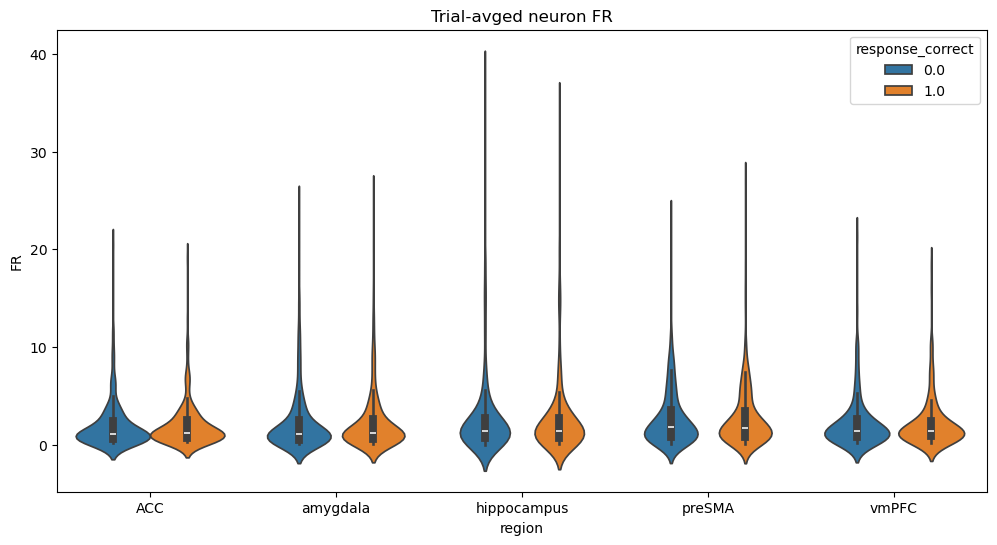

In [17]:
print(df_recognition.groupby(['region', 'response_correct']).size())

trial_avg_fr = df_recognition.groupby(['region', 'neuron', 'response_correct'])['FR'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.violinplot(data=trial_avg_fr, x='region', y='FR', hue='response_correct')
plt.title('Trial-avged neuron FR')
plt.show()


### trial-avged FR by confidence+correctness

region       conf_corr          
ACC          Confident & Correct    3673
             Other                  4013
amygdala     Confident & Correct    8040
             Other                  7711
hippocampus  Confident & Correct    4498
             Other                  4281
preSMA       Confident & Correct    5314
             Other                  4965
vmPFC        Confident & Correct    3044
             Other                  2839
dtype: int64


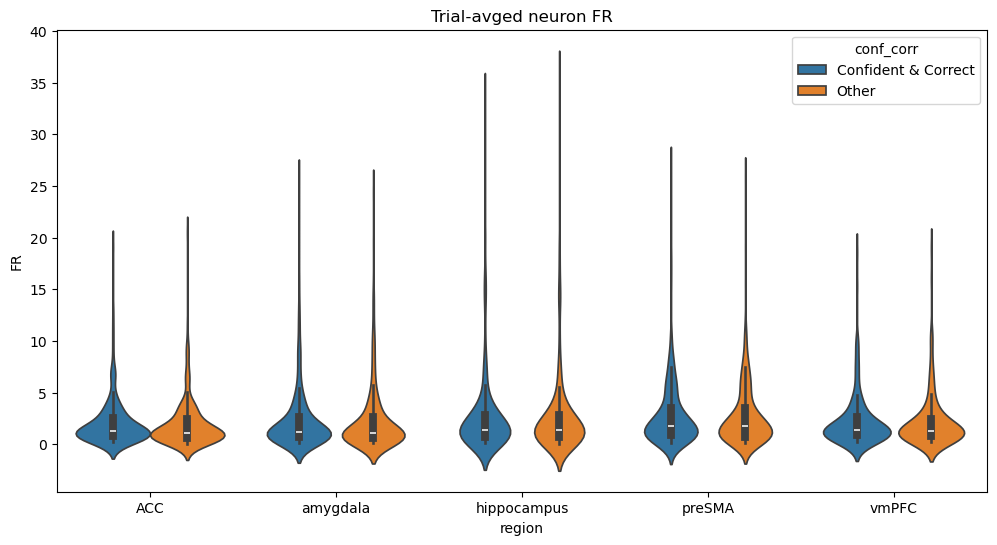

In [18]:
df_recognition['conf_corr'] = df_recognition.apply(lambda row: 'Confident & Correct' if row['response_confidence'] == 3 and row['response_correct'] == 1 else 'Other', axis=1)
print(df_recognition.groupby(['region', 'conf_corr']).size())

trial_avg_fr = df_recognition.groupby(['region', 'neuron', 'conf_corr'])['FR'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.violinplot(data=trial_avg_fr, x='region', y='FR', hue='conf_corr')
plt.title('Trial-avged neuron FR')
plt.show()
